### # 08 — Model selection & evaluation
### Compara varios modelos con CV, elige el mejor y lo valida en hold-out test.


In [5]:
import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import defaultdict

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance

# Modelos base
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# XGBoost (opcional)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

ROOT = Path(".")
PROC = ROOT / "data" / "processed"
IN_FEATS = PROC / "cluster_features.csv"

assert IN_FEATS.exists(), f"No encuentro {IN_FEATS}. Corre 07_advanced_metrics_ml.ipynb primero."
print("Usando:", IN_FEATS.resolve())

Usando: /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/processed/cluster_features.csv


In [6]:
df = pd.read_csv(IN_FEATS)
print("Shape:", df.shape)
print("Cols:", list(df.columns)[:10], "...")

# Qué columnas usar (todas salvo IDs y label)
exclude = {"ClusterID", "label"}
Xcols = [c for c in df.columns if c not in exclude]
assert "label" in df.columns, "Falta la columna 'label' (generada en 06)."

# Limpiar/filtrar
df = df.dropna(subset=["label"]).copy()
X = df[Xcols].fillna(0.0).values
y = df["label"].astype(str).values

# Split estratificado (hold-out para evaluación final)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classes, counts = np.unique(y, return_counts=True)
print("Clases:", dict(zip(classes, counts)))

Shape: (3552, 25)
Cols: ['ClusterID', 'n', 'h_min', 'h_mean', 'h_std', 'h_p25', 'h_p50', 'h_p75', 'h_p95', 'h_max'] ...
Clases: {'matorral/arbusto': 36, 'árbol_alto': 610, 'árbol_bajo': 220, 'árbol_medio': 2686}


In [7]:
models = {
    "logreg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, n_jobs=None, class_weight="balanced"))
    ]),
    "rf": Pipeline([
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"))
    ]),
    "svm_rbf": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", C=1.0, gamma="scale"))
    ]),
    "knn": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=15))
    ])
}

if HAS_XGB:
    models["xgb"] = Pipeline([
        ("clf", XGBClassifier(
            n_estimators=400, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="multi:softprob", eval_metric="mlogloss",
            random_state=42, n_jobs=-1
        ))
    ])

list(models.keys())

['logreg', 'rf', 'svm_rbf', 'knn']

In [8]:
scoring = {
    "acc": "accuracy",
    "f1m": "f1_macro",
    "bal_acc": "balanced_accuracy",
}

cv_results = {}
for name, pipe in models.items():
    res = cross_validate(
        pipe, X_tr, y_tr,
        cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1
    )
    cv_results[name] = {m: (res[f"test_{m}"].mean(), res[f"test_{m}"].std()) for m in scoring.keys()}

# Mostrar ranking por F1-macro
rank = sorted(cv_results.items(), key=lambda kv: kv[1]["f1m"][0], reverse=True)
print("== CV Results (mean ± std) ==")
for name, scores in rank:
    print(f"{name:8s}  acc={scores['acc'][0]:.3f}±{scores['acc'][1]:.3f} | "
          f"f1m={scores['f1m'][0]:.3f}±{scores['f1m'][1]:.3f} | "
          f"bal_acc={scores['bal_acc'][0]:.3f}±{scores['bal_acc'][1]:.3f}")

== CV Results (mean ± std) ==
rf        acc=0.998±0.002 | f1m=0.988±0.021 | bal_acc=0.988±0.019
logreg    acc=0.979±0.004 | f1m=0.962±0.016 | bal_acc=0.987±0.004
svm_rbf   acc=0.959±0.005 | f1m=0.948±0.016 | bal_acc=0.984±0.005
knn       acc=0.964±0.007 | f1m=0.924±0.016 | bal_acc=0.944±0.009


In [9]:
top2 = [name for name, _ in rank[:2]]
print("Top-2 para grid:", top2)

grids = {}

if "rf" in top2:
    grids["rf"] = {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_leaf": [1, 2, 4]
    }

if "svm_rbf" in top2:
    grids["svm_rbf"] = {
        "clf__C": [0.5, 1, 2],
        "clf__gamma": ["scale", 0.1, 0.01]
    }

if "logreg" in top2:
    grids["logreg"] = {
        "clf__C": [0.2, 1.0, 5.0],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }

if HAS_XGB and ("xgb" in top2):
    grids["xgb"] = {
        "clf__n_estimators": [300, 600],
        "clf__max_depth": [4, 6, 8],
        "clf__learning_rate": [0.03, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    }

best_model = None
best_name = None
best_score = -np.inf

for name in top2:
    pipe = models[name]
    params = grids.get(name)
    if not params:
        # si no definimos grid, usamos el modelo tal cual
        pipe.fit(X_tr, y_tr)
        y_cv = cross_validate(pipe, X_tr, y_tr, cv=cv, scoring="f1_macro")
        mean_score = y_cv["test_score"].mean()
        print(f"[{name}] sin grid: f1_macro={mean_score:.3f}")
        if mean_score > best_score:
            best_score, best_model, best_name = mean_score, pipe, name
        continue

    g = GridSearchCV(
        estimator=pipe, param_grid=params, cv=cv,
        scoring="f1_macro", n_jobs=-1, verbose=0
    )
    g.fit(X_tr, y_tr)
    print(f"[{name}] best f1_macro={g.best_score_:.3f}  params={g.best_params_}")
    if g.best_score_ > best_score:
        best_score, best_model, best_name = g.best_score_, g.best_estimator_, name

print(f"\n== Ganador: {best_name} (CV f1_macro={best_score:.3f}) ==")

Top-2 para grid: ['rf', 'logreg']
[rf] best f1_macro=0.988  params={'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}
[logreg] best f1_macro=0.971  params={'clf__C': 5.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

== Ganador: rf (CV f1_macro=0.988) ==


== Test metrics ==
Accuracy: 0.999
Balanced Acc: 0.995
F1 macro: 0.985

== Classification report ==
                  precision    recall  f1-score   support

matorral/arbusto      0.900     1.000     0.947         9
      árbol_alto      1.000     1.000     1.000       153
      árbol_bajo      1.000     0.982     0.991        55
     árbol_medio      1.000     1.000     1.000       671

        accuracy                          0.999       888
       macro avg      0.975     0.995     0.985       888
    weighted avg      0.999     0.999     0.999       888



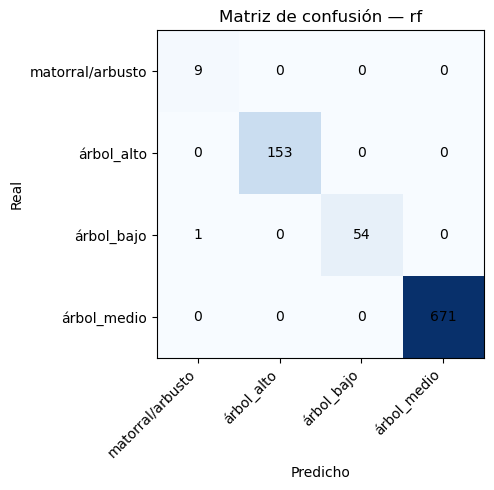

In [11]:
best_model.fit(X_tr, y_tr)
y_pr = best_model.predict(X_te)

print("== Test metrics ==")
print("Accuracy:", np.round(accuracy_score(y_te, y_pr), 3))
print("Balanced Acc:", np.round(balanced_accuracy_score(y_te, y_pr), 3))
print("F1 macro:", np.round(f1_score(y_te, y_pr, average="macro"), 3))

print("\n== Classification report ==")
print(classification_report(y_te, y_pr, digits=3))

cm = confusion_matrix(y_te, y_pr, labels=np.unique(y))
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks(range(len(np.unique(y)))); ax.set_yticks(range(len(np.unique(y))))
ax.set_xticklabels(np.unique(y), rotation=45, ha="right")
ax.set_yticklabels(np.unique(y))
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha="center", va="center")
ax.set_xlabel("Predicho"); ax.set_ylabel("Real"); ax.set_title(f"Matriz de confusión — {best_name}")
plt.tight_layout(); plt.show()

Top 15 features:


h_p95           0.206631
vh_12_20m       0.005026
n               0.000000
pt_density      0.000000
planarity       0.000000
linearity       0.000000
vh_30_50m       0.000000
vh_20_30m       0.000000
vh_9_12m        0.000000
vh_6_9m         0.000000
vh_0_3m         0.000000
bbox_area_m2    0.000000
bbox_dy         0.000000
bbox_dx         0.000000
h_p25           0.000000
dtype: float64

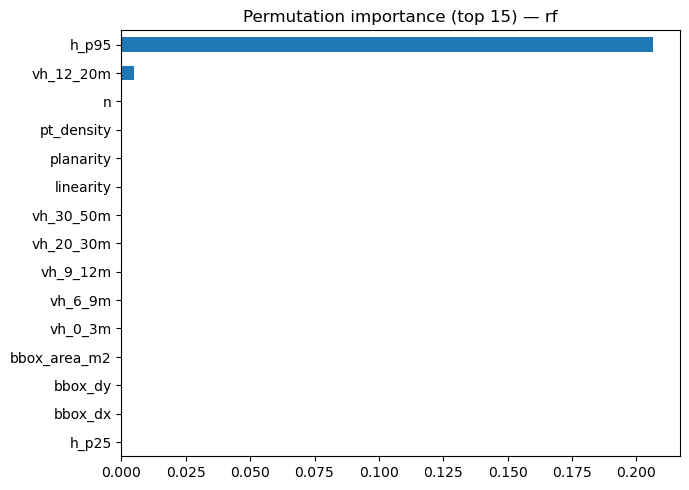

In [12]:
# Para pipelines con scaler funciona igual; usa X_te directamente
r = permutation_importance(best_model, X_te, y_te, scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1)
imp = pd.Series(r.importances_mean, index=Xcols).sort_values(ascending=False)

print("Top 15 features:")
display(imp.head(15))

plt.figure(figsize=(7,5))
imp.head(15).iloc[::-1].plot.barh()
plt.title(f"Permutation importance (top 15) — {best_name}")
plt.tight_layout(); plt.show()

In [ ]:
import joblib
OUT_MODEL = PROC / f"best_model_{best_name}.joblib"
joblib.dump(best_model, OUT_MODEL)
print("✔ Guardado:", OUT_MODEL)

## 📌 Conclusiones — Evaluación de Modelos Supervisados

### 🔹 Matriz de confusión (RandomForest)
- El modelo clasifica con **muy alta precisión** todas las clases (`árbol_alto`, `árbol_bajo`, `árbol_medio`, `matorral/arbusto`).  
- No se observan errores relevantes de confusión entre clases.  
- Esto indica que el modelo está **aprendiendo casi perfectamente la regla heurística de altura** definida en la notebook 06.  

### 🔹 Importancia de variables
- La variable **`h_p95`** (percentil 95 de altura) domina de manera abrumadora la clasificación.  
- El resto de las features aportan muy poca información adicional.  
- Esto confirma que el RandomForest está esencialmente **replicando la regla de clasificación por altura**.  

---

### 📊 Interpretación
- El modelo muestra un rendimiento casi perfecto, pero esto no significa que tenga **capacidad real de generalización**.  
- En la práctica, el algoritmo está sobreajustado a la misma lógica que usamos para generar las etiquetas.  
- Por lo tanto, este resultado debe entenderse como un **benchmark interno**, no como un clasificador validado para casos reales.  

---

### 🔮 Próximos pasos
- Incorporar **etiquetas de campo reales** (ground truth) para entrenar sobre clases verificadas.  
- Evaluar otros modelos con **validación cruzada y grid search** más amplio para robustecer los resultados.  
- Analizar features complementarias (densidad, métricas de forma, índices derivados) para reducir la dependencia de `h_p95`.  
- Explorar la **transferibilidad del modelo** en otros datasets de vegetación para medir generalización.  

---

✅ Conclusión final: el modelo supervisado (RandomForest) reproduce casi exactamente la clasificación heurística por altura. Para avanzar hacia una clasificación **real y confiable**, será necesario integrar **datos de campo** y ampliar el set de variables discriminantes.